In [1]:
from models.utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from models.diffusion_model import *

In [2]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn, z_dim=784))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

dataset = MNIST('../data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [16]:
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    x_jpeg = jpeg_compress(x, quality=10)
    loss = loss_fn(score_model, x, x_jpeg, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [30]:
_, (x, y) = next(enumerate(data_loader))
x = x.to(device)

x_jpeg = jpeg_compress(x, quality=90)

In [31]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid
from models.samplers import *

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

select_t = 0.3 #@param {'type':'number'}
x_ = forward_process(x, marginal_prob_std_fn, 500, device=device, end_t=select_t, only_final=True)

In [32]:
from models.jscc import *
autoencoder = Autoencoder(in_channels=1,
                c=8,
                snr=0)
autoencoder.load_state_dict(torch.load('./checkpoints/jscc.pt', map_location=device))

<All keys matched successfully>

In [33]:
autoencoder.to(device)
jscc_x = autoencoder(x_)

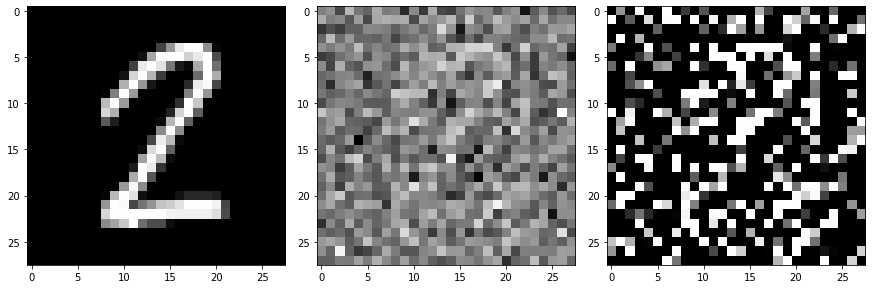

In [34]:
import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 4), constrained_layout = True)
axs[0].imshow(ani_imshow(x[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[1].imshow(ani_imshow(x_[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[2].imshow(ani_imshow(jscc_x[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')

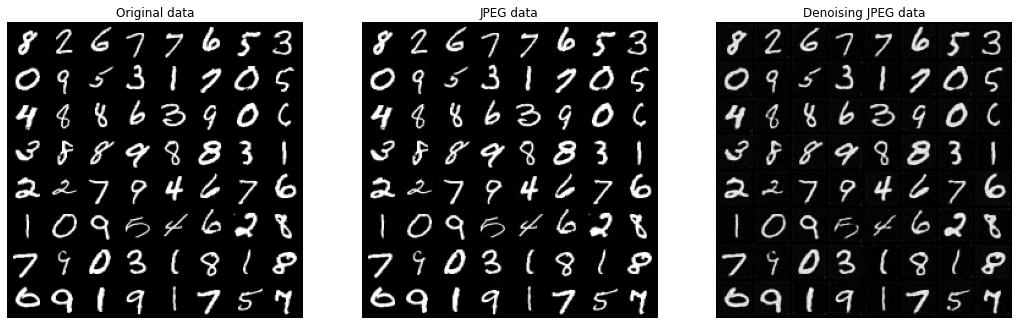

In [35]:
## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                  x=jscc_x.detach(),
                  z=x_jpeg.reshape(x_jpeg.shape[0], -1),
                  start_t=select_t,
                  )

## Sample visualization.
samples = samples.clamp(0.0, 1.0)

imgs_int = (x.clone().detach()*255).to(dtype=torch.uint8)
decoded_imgs_int = (samples.clone().detach()*255).to(dtype=torch.uint8)
imgs_jpeg_int = (x_jpeg.clone().detach()*255).to(dtype=torch.uint8)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(decoded_imgs_int, nrow=int(np.sqrt(sample_batch_size)))
sample_ori = make_grid(imgs_int, nrow=int(np.sqrt(sample_batch_size)))
sample_jpeg = make_grid(imgs_jpeg_int, nrow=int(np.sqrt(sample_batch_size)))
fig, axs = plt.subplots(1, 3, figsize=(3 * 6, 6))
# plt.figure(figsize=(6,6))
plt.axis('off')
axs[0].imshow(sample_ori.permute(1, 2, 0).cpu(), vmin=0., vmax=255.)
axs[0].set_axis_off()
axs[0].set_title('Original data')
axs[1].imshow(sample_jpeg.permute(1, 2, 0).cpu(), vmin=0., vmax=255.)
axs[1].set_axis_off()
axs[1].set_title('JPEG data')
axs[2].imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=255.)
axs[2].set_axis_off()
axs[2].set_title('Denoising JPEG data')
# plt.savefig('./Compare.png')
plt.show()

In [36]:
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.functional import structural_similarity_index_measure

ssim = structural_similarity_index_measure
psnr = PeakSignalNoiseRatio().to('cuda')

In [37]:
ssim(imgs_int/255, decoded_imgs_int/255), ssim(imgs_int/255, imgs_jpeg_int/255), psnr(imgs_int/255, decoded_imgs_int/255), psnr(imgs_int/255, imgs_jpeg_int/255)

(tensor(0.8401, device='cuda:0'),
 tensor(0.9815, device='cuda:0'),
 tensor(22.3891, device='cuda:0'),
 tensor(40.8169, device='cuda:0'))

In [47]:
x_int = torch.tensor((x * 255), dtype=torch.uint8).cpu()

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


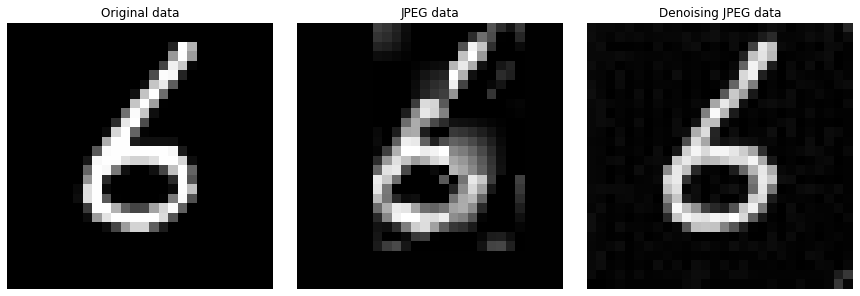

In [21]:
import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 4), constrained_layout = True)
axs[0].imshow(ani_imshow(x[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[0].set_axis_off()
axs[0].set_title('Original data')
axs[1].imshow(ani_imshow(x_jpeg[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[1].set_axis_off()
axs[1].set_title('JPEG data')
axs[2].imshow(ani_imshow(samples[1].view(-1, 1, 28, 28), sampling_number = 1), animated=True, cmap = 'gray')
axs[2].set_axis_off()
axs[2].set_title('Denoising JPEG data')

plt.savefig('./Compare_single.png')